# Midterm Project - Jordan Martin

#### Jordan Martin K-State Honor Code "On my honor, as a student, I have neither given nor received unauthorized aid on this academic work.
  
## Fantasy Football Projections

I have been playing fantasy football for many years now. Last year, I started a league with some of my college friends. The league is hosted on ESPN, but I don't really trust ESPN's projection model and prefer to use FantasyPros' projections which are an average of several projection models. For my midterm project, I thought it would be fun and challenging to scrape data from ESPN and FantasyPros, join the data, compare the accuracy of the predictions to the actual scores that the players get and finally give some interesting visuals that provide insights into the data. At the end, I will be able to test my hypothesis that FantasyPros is more accurate and hopefully this will give me an edge in my fantasy football leagues. I will also definitely reuse some of the functions I create to create weekly optimal lineups for my teams.

### Web Scraping

To complete this project, I needed to scrape both the ESPN and FantasyPros websites. The FantasyPros website was very simple and didn't have a lot of columns for each position, so I just used pandas.io.html.read_html that converts html into a dataframe. I learned this by looking at examples online. Unfortunately, the ESPN website returns a very complex JSON object. Therefore, I had to go through and scrape out just the data that I wanted to keep.

#### Notes about these scraping functions

For the ESPN scraping functions, I used some documentation gathered by Steven Morse as noted in the comments. ESPN uses an API, but does not publish any documentation for programmers to use for some strange reason. Because of this, I did some googling and found some things that Steven wrote that definitely helped with getting started in examining and using their API. Also, for some reason there are some missing values for FantasyPros. For example, in week 1, there are projections for a running back, but his name is not given. To account for that, I had to add some checking before adding them to the dataframe. This was an excellent way for me to practice handling missing data like we discussed in class. Finally, there appears to be a bug with FantasyPros for quarterbacks where players that are currently not playing do not show up in the projections in previous weeks. I will note how this affects the outcomes at the end of this notebook. For example, Drew Brees and Ben Roethlisberger are both injured now, but both played in week 1. FantasyPros website has removed projections for them in that week, so my scraping fills their projections out with zeroes. I do account for this later when analyzing the two projection models, however.

In [1]:
import requests as req #to make web requests
import pandas as pd #to use dataframe objects for visualization and processing
from IPython.display import display # for pretty printing of dataframes
import matplotlib.pyplot as plt # for manipulating plot
#hides warnings
import warnings
from statistics import mean
warnings.filterwarnings('ignore')
# Deals with potential issues with infinite values
pd.set_option('use_inf_as_na', True)

# FantasyPros

# get fantasy projections from fantasypros.com for a given week and scoring format (outputs to csv files)
def scrape_fp_data(week, scoring):
    position_list = ['qb', 'rb', 'wr', 'te', 'flex', 'dst'] # list of positions in my league
    fantasypros_url = 'http://www.fantasypros.com/nfl/projections' # one of my favorite fantasy websites
    projections = []
    for position in position_list:
        position_url = '%s/%s.php' % (fantasypros_url, position) # append position to url
        params = {'week': week, 'scoring': scoring} # adds week and scoring to url with ? and =
        response = req.get(position_url, params=params)
        header = 1 # most positions have a weird first row, this gets rid of it
        if position is 'dst': # defenses don't have that weird row, so we don't get rid of it
            header = 0
        data = pd.io.html.read_html( #gets a dataframe with all of the data for a position
                response.text,
                attrs={'id': 'data'},
                header=header
            )[0]
        # create full list of projections excluding flex to avoid duplicates
        if position is not 'flex':
            projections.append(data)
        # to align with ESPN naming conventions
        if position is 'dst':
            # for each defense, grab just the team name and append "D/ST"
            for i in range(len(data['Player'])):
                temp = data['Player'][i].split(" ")
                team = temp[len(temp) - 1]
                data['Player'][i] = team + " D/ST"
        else:
            # for each player, remove the team abbreviation
            for i in range(len(data['Player'])):
                # avoids some weird errors where FantasyPros has missing data
                if type(data['Player'][i]) is not float:
                    temp = data['Player'][i].split(" ")
                    abb = temp[len(temp) - 1]
                    data['Player'][i] = data['Player'][i].replace(' ' + abb,'')
        # ouput to a file for each position
        filename = 'fantasydata/fantasy-pros-week-{}-{}-{}-projections.csv'.format(week,position,scoring.lower())
        data.to_csv(filename, index=False)
    # combine all projections into one dataframe and return that dataframe
    full_proj = pd.concat(projections, axis=0)
    return full_proj
        
# ESPN
# some code is inspired by: https://stmorse.github.io/journal/espn-fantasy-projections.html
# this was necessary because ESPN's API is not documented, but has instead been played with
# by the fantasy community like Steven Morse

# slotcodes ESPN uses to differentiate positions 
# list found at url listed above
slotcodes = {
    0 : 'QB', 1 : 'QB',
    2 : 'RB', 3 : 'RB',
    4 : 'WR', 5 : 'WR',
    6 : 'TE', 7 : 'TE',
    16: 'D/ST',
    20: 'Bench',
    21: 'IR',
    23: 'Flex'
}

# returns json of the given week in the given season in the given league's matchup data
def get_matchups(week, season, league_id, swid='', cookie=''):
    return req.get("https://fantasy.espn.com/apis/v3/games/ffl/seasons/" + str(season) + "/segments/0/leagues/" + str(league_id) + "?view=mMatchup&view=mMatchupScore",
                     cookies={"swid": swid, "espn_s2": cookie},
                        params={'scoringPeriodId': week, 'matchupPeriodId': week}).json()

# using matchup data gathered from get_matchups, this returns a given week's rosters for each team
def get_rosters(data, league_id, week):
    rosters = {}
    # for each team in the data
    for team in data['teams']:
        roster = []
        for player in team['roster']['entries']:
            # get name
            name  = player['playerPoolEntry']['player']['fullName']
            # get actual lineup slot
            slotid = player['lineupSlotId']
            slot = slotcodes[slotid]
            # get projected and actual scores
            act, proj = 0, 0
            # for each statistic a player has
            for stat in player['playerPoolEntry']['player']['stats']:
                # if the stats are for the current week
                if int(stat['scoringPeriodId']) == int(week):
                    # zero is for actual point total
                    if stat['statSourceId'] == 0:
                        act = stat['appliedTotal']
                    # one is for projected point total
                    elif stat['statSourceId'] == 1:
                        proj = stat['appliedTotal']
            # get type of player
            pos = 'NONE'
            # determine the position based on the eligible slots a player has
            eligible = player['playerPoolEntry']['player']['eligibleSlots']
            if 0 in eligible: pos = 'QB'
            elif 2 in eligible: pos = 'RB'
            elif 4 in eligible: pos = 'WR'
            elif 6 in eligible: pos = 'TE'
            elif 16 in eligible: pos = 'DST'
            # corrects names that are different between FantasyPros and ESPN
            if name == "Darrell Henderson Jr.": name = "Darrell Henderson"
            elif name == "DJ Moore": name = "D.J. Moore"
            elif name == "Will Fuller V": name = "Will Fuller"
            elif name == "Allen Robinson II": name = "Allen Robinson"
            elif name == "Mark Ingram II": name = "Mark Ingram"
            elif name == "DK Metcalf": name = "D.K. Metcalf"
            elif name == "Todd Gurley II": name = "Todd Gurley"
            elif name == "Ted Ginn Jr.": name = "Ted Ginn"
            elif name == "John Ross III": name = "John Ross"
            elif name == "Gardner Minshew II": name= "Gardner Minshew"
            elif name == "DJ Chark Jr.": name = "D.J. Chark"
            elif name == "Paul Richardson Jr.": name = "Paul Richardson"
            elif name == "Marvin Jones Jr.": name = "Marvin Jones"
            # add the roster data to the list of roster data
            roster.append([name, slotid, slot, pos, act, proj])
        # rename columns to better names
        roster = pd.DataFrame(roster, columns=['Name', 'SlotID', 'Slot', 'Position', 'Actual', 'ESPN_Proj'])
        # add the roster to the roster dictionary with a key of team id
        rosters[team['id']] = roster
        # output the roster data to a csv file
        filename = 'fantasydata/espn-week-{}-{}-{}-projections.csv'.format(week, league_id, team['id'])
        roster.to_csv(filename, index=False)
    return rosters

### Example Scrape (takes a couple minutes to get all data)

For the web scraping example, I am using variables specific to my fantasy football league. The swid and cookie are used by ESPN to validate that I have access to the league and its data. I am also passing the league id, season and list of the weeks so far this year. For FantasyPros, there are three different projections depending on the scoring settings of the league. My league awards players half a point per reception, so my scoring setting is 'HALF'. With this code, I create a list of dictionaries of dataframes with keys that are the team's ids. This list includes every roster from every team from every week. I also gather FantasyPros projections for each position, output them to csv files and return them in an array of dataframes, one for each position. The reason that I output all of the data from both sources into csv files is so that in the future when I want to re-use this data for other projects, I can do that without having to re-scrape for the data which takes a long time.

In [2]:
# variables for potential re-use
# cookies necessary for ESPN permissions found on my local machine
swid = "{6A5B8F6A-2E48-45FB-BEF5-620ECFC33CA3}"
cookie = ("AECcnq1V99Oz4MHn2JGtEb4gRsFRvpqV0vL"
          "%2F1hQYB6W0D7J1OQ5RDr8F5ah5qiX9%2FS"
          "%2FFJh0Qa8aXl0wMSqE49AqF8Jk5b39Uc3g"
          "VfjIJ3A8d0dbyFmZwhxaEq1cRGJTjQgljWL"
          "UvnmzAkuDmQEcUDNcyTXXUn7BSEACPa6ezI"
          "78lrDnvB9PObt6a6JP48UpI97uqKbsli8XI"
          "g6Vu8AZqaEhoQd9mifRQnZ6Rdznt1%2BVJ%"
          "2Fgc7jeCuOdQ4a9u6OiWqJtEa3yYSegpPwq"
          "PmxSlrIbcR")
# ESPN league id for my fantasy league
league_id = 165378
# current season
season = 2019
# previous weeks of the season
weeks = [1,2,3,4,5]
# scoring - can be STD, HALF or PPR. My league is HALF
scoring = "HALF"
# my ESPN team's id
team_id = 7
# get fantasy pros projections
fp_projections = []
for week in weeks:
    fp_projections.append(scrape_fp_data(week, scoring))
# get ESPN matchups
matchups = []
for week in weeks:
    matchups.append(get_matchups(week, season, league_id, swid=swid, cookie=cookie))
# get rosters for all teams in all weeks
rostersByWeek = []
a = 0
for week in weeks:
    rostersByWeek.append(get_rosters(matchups[a], league_id, week))
    a = a + 1

### Joining Data From Two Sources

This join combines data from ESPN and FantasyPros into one DataFrame. I decided to do a left join the Player and FPTS columns of the FantasyPros data with the ESPN data. The key I used for the join was matching the ESPN Name with the FantasyPros Player columns. I then sorted the data to make it ordered like in the ESPN webpage and deleted some extraneous columns. I did this by transforming the slot ID that I got from ESPN into a modified slot ID with QB first, then RB, then WR, then Flex and finally D/ST, just like how rosters are listed in ESPN's web interface.

When I was working on this join, I realized that some names were slightly different between the two datasets. Below is a list of the names I needed to transform (ESPN name : FP name):

- Darrell Henderson Jr. : Darrell Henderson
- DJ Moore : D.J. Moore
- Will Fuller V : Will Fuller
- Allen Robinson II : Allen Robinson
- Mark Ingram II : Mark Ingram
- DK Metcalf : D.K. Metcalf
- Todd Gurley II : Todd Gurley
- Ted Ginn Jr. : Ted Ginn
- John Ross III : John Ross
- Gardner Minshew II : Gardner Minshew
- DJ Chark Jr. : D.J. Chark
- Paul Richardson Jr. : Paul Richardson
- Marvin Jones Jr. : Marvin Jones

It's obvious that ESPN doesn't like using periods and likes using suffixes while FantasyPros is the other way around. Strangely, FantasyPros does refer to Odell Beckham Jr. and Ronald Jones II with their suffixes. Also, ESPN refers to A.J. Green with periods in his name. This inconsistency was annoying, but was good practice for things to look out for when joining data between sources that may not be exactly one-to-one.

In [3]:
def get_team(fp_projections, rosters, team_id):
    # get roster for my team and join fantasy pros projections
    team = pd.merge(rosters[team_id], fp_projections[['Player','FPTS']], left_on='Name', right_on='Player', how='left')
    # mapping slotID 23 to 8 in order for sorting by default ESPN roster setup
    team['SlotID'] = team['SlotID'].map({0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,16:16,20:20,21:21,23:8})
    team = team.sort_values(by='SlotID')
    # deleting unused columns
    del team['Player']
    del team['SlotID']
    # renaming a few columns
    team = team.rename(columns={'Name':'Player','FPTS':'FP_Proj'})
    # change missing projections to zeros
    team['FP_Proj'] = team['FP_Proj'].fillna(0)
    return team
teams = []
# loop through each week
for j in range(len(rostersByWeek)):
    # loop through each team in a week
    for i in range(1,13):
        # compile all rosters with both projections into an array
        team = get_team(fp_projections[j], rostersByWeek[j], i)
        teams.append(team)

### Transforming Data

The original purpose of this project was to evaluate ESPN and FP projections. To do this effectively, I calculated the error for each (actual - projected)/actual. This data transformation will allow us to look at some data visualizations in the next step and also allows us to get the average ESPN and FP errors and also allows us to calculate the mean of the means, thereby finding the effective error of both of the projections. My results were that ESPN averaged 113% error and FantasyPros averaged 108% error. So my original idea was correct ESPN's projections are not very good, but FantasyPros' projections aren't really that much better. As noted earlier, some quarterback data is not included for FantasyPros which does mean that their projections are likely slightly better than what I calculated.  We will use these errors in the next step as well as we visualize how the two projections did in comparison to one another.

In [4]:
espn_means = []
fp_means = []
# for each team across each week
for i in range(len(teams)):
    # calculate error for ESPN and FP
    teams[i]['ESPN_Error'] = abs(teams[i]['Actual']-teams[i]['ESPN_Proj'])/abs(teams[i]['Actual'])
    teams[i]['FP_Error'] = abs(teams[i]['Actual']-teams[i]['FP_Proj'])/abs(teams[i]['Actual'])
    teams[i]['ESPN_Error'] = teams[i]['ESPN_Error'].fillna(0)
    teams[i]['FP_Error'] = teams[i]['FP_Error'].fillna(0)
    # get the average errors
    espn_means.append(teams[i]['ESPN_Error'].mean())
    fp_means.append(teams[i]['FP_Error'].mean())
    # display data for the first two teams only (so that we don't make the html too long)
    if i in range(2):
        display(teams[i])

,Player,Slot,Position,Actual,ESPN_Proj,FP_Proj,ESPN_Error,FP_Error
7,Lamar Jackson,QB,QB,33.56,18.852494,20.0,0.438245,0.404052
2,Sony Michel,RB,RB,1.40,11.467381,12.7,7.190986,8.071429
0,Davante Adams,WR,WR,5.60,13.704322,16.9,1.447200,2.017857
3,Cooper Kupp,WR,WR,8.10,10.419594,12.4,0.286370,0.530864
1,Travis Kelce,TE,TE,10.30,13.660077,14.0,0.326221,0.359223
4,Calvin Ridley,Flex,WR,14.40,9.401484,8.7,0.347119,0.395833
5,Josh Gordon,Flex,WR,14.80,10.779494,11.2,0.271656,0.243243
12,Seahawks D/ST,D/ST,DST,8.00,4.599739,7.9,0.425033,0.012500
6,Devin Singletary,Bench,RB,12.30,9.105697,7.9,0.259699,0.357724
8,Dante Pettis,Bench,WR,1.20,8.496952,10.2,6.080793,7.500000


,Player,Slot,Position,Actual,ESPN_Proj,FP_Proj,ESPN_Error,FP_Error
8,Carson Wentz,QB,QB,25.02,19.252511,18.8,0.230515,0.248601
0,Alvin Kamara,RB,RB,20.40,18.615232,19.9,0.087489,0.024510
3,Tyler Lockett,WR,WR,10.90,10.740700,14.9,0.014615,0.366972
4,Tyler Boyd,WR,WR,10.30,11.460687,13.4,0.112688,0.300971
2,George Kittle,TE,TE,9.40,12.317018,13.1,0.310321,0.393617
1,Nick Chubb,Flex,RB,10.00,16.366398,16.8,0.636640,0.680000
5,Tevin Coleman,Flex,RB,6.60,10.513287,10.4,0.592922,0.575758
12,Cowboys D/ST,D/ST,DST,1.00,4.840028,7.9,3.840028,6.900000
6,Robby Anderson,Bench,WR,3.80,9.729146,10.3,1.560302,1.710526
7,Rashaad Penny,Bench,RB,1.80,8.474559,7.5,3.708088,3.166667


In [5]:
# print the results
print('Average ESPN Error : ' + str(mean(espn_means)))
print('Average FP Error   : ' + str(mean(fp_means)))

Average ESPN Error : 1.1262041947464174
Average FP Error   : 1.0756420989909756


### Visualizing Data

While we have seen that FantasyPros is better so far for this whole season, it would be nice to be able to see how this varies by week. In the code below, we compile the mean percent error for each of the projections for each week in an array. We then convert that array into a dataframe and plot it in a line plot. From the plot that is produced, we can see that it appears that the two projections are very correlated. When one of the projections does more poorly, the other also does more poorly and vice versa. Week 4 was especially bad for both of the projections which means that the real life NFL games did not go the way that these models thought they would. On the other hand, last week (week 5) was better than most weeks for both of the models. Finally, we see that FantasyPros outperformed ESPN in three of the five weeks with two and four having significant gaps between the two models. All of this while my data was slightly off for FantasyPros meaning they would have likely done even better if QB data was not missing for currently injured QBs.

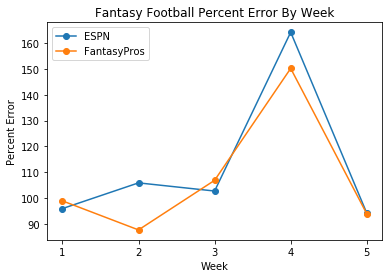

In [6]:
error = []
# for each week
for i in range(len(weeks)):
    espnError = 0
    fpError = 0
    # for each team in the league
    for j in range(12):
        # get the mean error for each projection
        espnError = espnError + teams[i*12 + j]['ESPN_Error'].mean()
        fpError = fpError + teams[i*12 + j]['FP_Error'].mean()
    # add the percent error to the array
    error.append([(espnError/12)*100,(fpError/12)*100])
# convert to a dataframe
error = pd.DataFrame(error, columns=['ESPN','FantasyPros']).rename(index={0:1,1:2,2:3,3:4,4:5})
# plot the data in a line graph
error.plot(marker='o')
plt.xlabel('Week')
plt.ylabel('Percent Error')
plt.title('Fantasy Football Percent Error By Week')
plt.xticks([1,2,3,4,5])
plt.legend()
plt.show()

### Conclusion

Thus far in MIS 665, I have learned a lot about how to use Python and in particular, the Pandas package, to gather, process, visualize and analyze data. Early on in this course, I learned how to scrape the web for data. In this project, I scraped data from two different fantasy football websites using two techniques that were slightly different (and easier) than what we learned in class. Once I collected that data, I had to do some data manipulation to make the names of the players the same between both datasets. Then, I joined the data sets so that I had ESPN's projections, FantasyPros' projections and the actual scores that each player got for the first five weeks of the season. Using this data, I transformed it to calculate the percentage error for both of the projections for every player in every week. I then aggregated the data, and found that my hypothesis was correct. FantasyPros is more accurate than ESPN. However, I also found that neither projection is all that accurate. Finally, I visualized the data by creating a line plot that compares the accuracy between the two for each week of the season so far. This was very enlightening because it showed me that the two projections have been pretty consistent most weeks with week 2 being better for FantasyPros and that likely is the main reason that FantasyPros performed better overall. This project was very helpful for me as it showed me how to put all of the concepts I've learned together to produce some useful outputs.

### Future Work

In the future, I plan to utilize these functions that I have created not only to evaluate the performance of FantasyPros and ESPN across the rest of the season, but also to help set my fantasy football lineups automatically for future weeks. Also, with the ESPN data, I would like to create some sort of power ranking for the fantasy football teams in my leagues and maybe even develop my own projection model. The possibilities of where this project could lead me are truly endless!